In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.ndimage.measurements import label
from skimage.feature import hog
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from moviepy.editor import VideoFileClip
%matplotlib inline

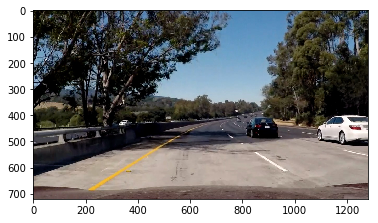

In [2]:
image = mpimg.imread('test_images/test5.jpg')
plt.imshow(image)
plt.show()

In [3]:
# function to change the color-space
def convert_color(image, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(image)
    return feature_image

In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [5]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))           

In [6]:
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [7]:
# extract features
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        #imageBGR = cv2.imread(file) # BGR format
        # Convert BGR to RGB
        #image = cv2.cvtColor(imageBGR, cv2.COLOR_BGR2RGB)
        image = mpimg.imread(file)
        
        # apply color conversion if other than 'RGB'
        feature_image = convert_color(image, color_space=color_space)
        
        # Extract spatial binning features    
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        
        # Extract histogram features
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        
        # Extract HOG features
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [8]:
# extract features
def extract_single_features(image, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    # apply color conversion if other than 'RGB'
    feature_image = convert_color(image, color_space=color_space)

    # Extract spatial binning features    
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        file_features.append(spatial_features)

    # Extract histogram features
    if hist_feat == True:
        # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        file_features.append(hist_features)

    # Extract HOG features
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        file_features.append(hog_features)
    features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [9]:
# .png images- so use cv2.imread()
cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')
print('number of car images ',len(cars), '\nnumber of non car images ', len(notcars))

number of car images  8792 
number of non car images  8968


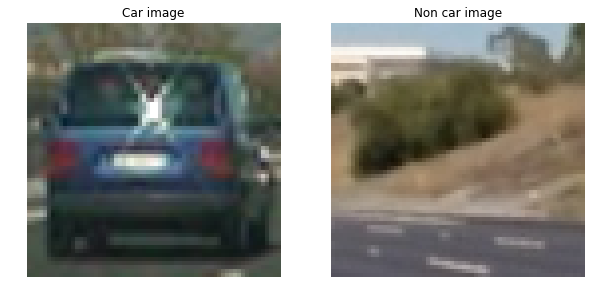

In [10]:
# examples of a car image from the dataset
car_image = mpimg.imread(cars[200])
non_car_image = mpimg.imread(notcars[300])

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(car_image)
plt.title('Car image')
plt.axis('off')

plt.subplot(122)
plt.imshow(non_car_image)
plt.title('Non car image')
plt.axis('off')
plt.savefig('examples/sample_image.jpg')

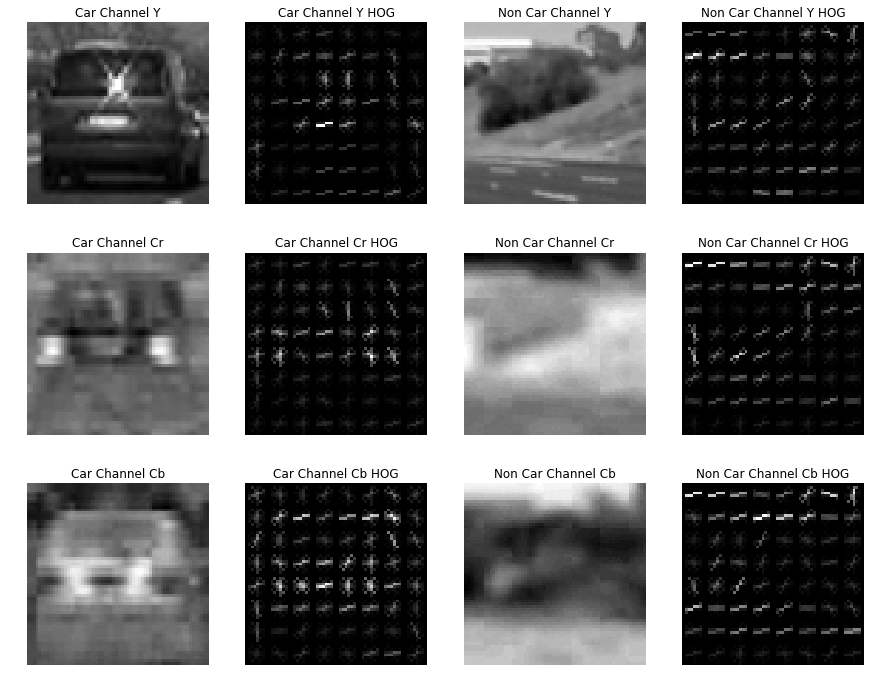

In [11]:
car_image_conv = convert_color(car_image, color_space = "YCrCb")
feats1, hog_car_image1 = get_hog_features(car_image_conv[:,:,0], orient=9, pix_per_cell=8, cell_per_block=2, 
                        vis=True, feature_vec=True)
feats2, hog_car_image2 = get_hog_features(car_image_conv[:,:,1], orient=9, pix_per_cell=8, cell_per_block=2, 
                        vis=True, feature_vec=True)
feats3, hog_car_image3 = get_hog_features(car_image_conv[:,:,2], orient=9, pix_per_cell=8, cell_per_block=2, 
                        vis=True, feature_vec=True)

non_car_image_conv = convert_color(non_car_image, color_space = "YCrCb")
feats1, hog_non_car_image1 = get_hog_features(non_car_image_conv[:,:,0], orient=9, pix_per_cell=8, cell_per_block=2, 
                        vis=True, feature_vec=True)
feats2, hog_non_car_image2 = get_hog_features(non_car_image_conv[:,:,1], orient=9, pix_per_cell=8, cell_per_block=2, 
                        vis=True, feature_vec=True)
feats3, hog_non_car_image3 = get_hog_features(non_car_image_conv[:,:,2], orient=9, pix_per_cell=8, cell_per_block=2, 
                        vis=True, feature_vec=True)

plt.figure(figsize=(15,12))
plt.subplot(341)
plt.imshow(car_image_conv[:,:,0], cmap='gray')
plt.title('Car Channel Y')
plt.axis('off')

plt.subplot(342)
plt.imshow(hog_car_image1, cmap='gray')
plt.title('Car Channel Y HOG')
plt.axis('off')

plt.subplot(343)
plt.imshow(non_car_image_conv[:,:,0], cmap='gray')
plt.title('Non Car Channel Y')
plt.axis('off')

plt.subplot(344)
plt.imshow(hog_non_car_image1, cmap='gray')
plt.title('Non Car Channel Y HOG')
plt.axis('off')

plt.subplot(345)
plt.imshow(car_image_conv[:,:,1], cmap='gray')
plt.title('Car Channel Cr')
plt.axis('off')

plt.subplot(346)
plt.imshow(hog_car_image2, cmap='gray')
plt.title('Car Channel Cr HOG')
plt.axis('off')

plt.subplot(347)
plt.imshow(non_car_image_conv[:,:,1], cmap='gray')
plt.title('Non Car Channel Cr')
plt.axis('off')

plt.subplot(348)
plt.imshow(hog_non_car_image2, cmap='gray')
plt.title('Non Car Channel Cr HOG')
plt.axis('off')

plt.subplot(349)
plt.imshow(car_image_conv[:,:,2], cmap='gray')
plt.title('Car Channel Cb')
plt.axis('off')

plt.subplot(3,4,10)
plt.imshow(hog_car_image3, cmap='gray')
plt.title('Car Channel Cb HOG')
plt.axis('off')

plt.subplot(3,4,11)
plt.imshow(non_car_image_conv[:,:,2], cmap='gray')
plt.title('Non Car Channel Cb')
plt.axis('off')

plt.subplot(3,4,12)
plt.imshow(hog_non_car_image3, cmap='gray')
plt.title('Non Car Channel Cb HOG')
plt.axis('off')

plt.savefig('examples/sample_hog.jpg')

In [12]:
# Set the parameters for feature extraction
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
#example_image = cv2.imread(cars[0])

In [13]:
# extract car features and not car features 
car_features = extract_features(cars, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, 
               orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
               hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
print('Car features extraction done!')
notcar_features = extract_features(notcars, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, 
                  orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                  hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
print('Not Car features extraction done!')

Car features extraction done!
Not Car features extraction done!


In [14]:
# Training using Linear SVM 
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
17.84 Seconds to train SVC...
Test Accuracy of SVC =  0.9927


In [15]:
def find_cars(img, color_space, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    #img = img.astype(np.float32)
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space=color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # List of bounding boxes
    bbox_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(255,0,0),8) 
                
    return draw_img, bbox_list

In [16]:
ystart = 400 # 400 (Original)
ystop = 656 # 656 (Original)
scale = 1.5

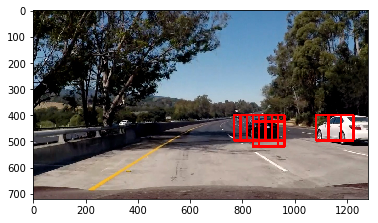

In [17]:
out_img, bbox_list = find_cars(image, color_space, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
plt.imshow(out_img)

In [18]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 8)
    # Return the image
    return img

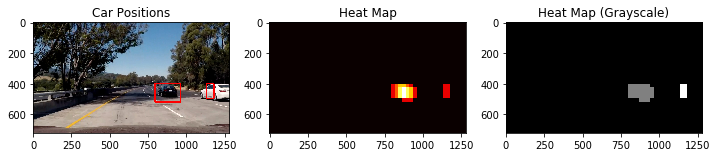

In [21]:
# Add heat to each box in box list
heat = add_heat(heat,bbox_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure(figsize=(10,3))
plt.subplot(131)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(132)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
plt.subplot(133)
plt.title('Heat Map (Grayscale)')
plt.imshow(labels[0], cmap='gray')
fig.tight_layout()
plt.savefig('examples/heat_map.jpg')

In [22]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(255, 0, 0), thick=8):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        #print('drawing')
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [23]:
def process_image(image):
    # Set parameters for feature extraction
    color_space = 'YCrCb'
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL'
    spatial_size = (32, 32)
    hist_bins = 32
    spatial_feat = True
    hist_feat = True
    hog_feat = True
    
    # Select the ROI in the image to search for cars
    ystart = 400
    ystop = 656
    scale = 1.5
    
    # Search for cars in the ROI
    out_img, bbox_list = find_cars(image, color_space, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    # Heatmap
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,bbox_list)
    heat = apply_threshold(heat,1)    
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_image = draw_labeled_bboxes(np.copy(image), labels)
    return draw_image

### Test pipeline on all test images

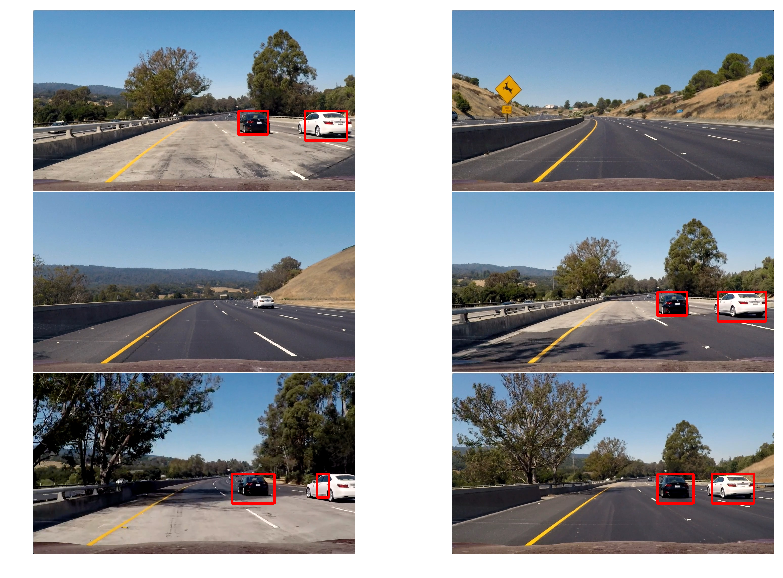

In [24]:
test_images = glob.glob('./test_images/*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(15,10))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, image in enumerate(test_images):
    axs[i].imshow(process_image(mpimg.imread(image)))
    axs[i].axis('off')
plt.savefig('examples/test_image_results.jpg')

In [25]:
# Test video - without removing false positives and without smoothing
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_image)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:19<00:00,  1.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 17.8 s, sys: 1.02 s, total: 18.9 s
Wall time: 21.3 s


In [26]:
project_out_file = 'test_project_video_out.mp4'
clip_project = VideoFileClip('project_video.mp4') #.subclip(23,26)  # subclip = only specified span of video
#clip_proj.save_frame('./test_images/project1.jpg', t=1.0) # saves the frame at time = t seconds
clip_project_out = clip_project.fl_image(process_image)
%time clip_project_out.write_videofile(project_out_file, audio=False)

[MoviePy] >>>> Building video test_project_video_out.mp4
[MoviePy] Writing video test_project_video_out.mp4


100%|█████████▉| 1260/1261 [10:15<00:00,  2.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_project_video_out.mp4 

CPU times: user 8min 55s, sys: 26.9 s, total: 9min 22s
Wall time: 10min 16s


### A class to store data from frames and vehicle detections

In [27]:
class Vehicle():
    def __init__(self):
        # bounding boxes detected in previous frames
        self.previous_bboxes = []
        
    def add_bboxes(self, bboxes):
        self.previous_bboxes.append(bboxes)
        if len(self.previous_bboxes) > 10:
            # ignore the old rectangles
            self.previous_bboxes = self.previous_bboxes[len(self.previous_bboxes)-10:]
            
def process_project_video(image):
    # Set parameters for feature extraction
    color_space = 'YCrCb'
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL'
    spatial_size = (32, 32)
    hist_bins = 32
    spatial_feat = True
    hist_feat = True
    hog_feat = True
    
    # Select the ROI in the image to search for cars
    ystart = 400
    ystop = 656
    scale = 1.5
    
    # Search for cars in the ROI
    out_img, bbox_list = find_cars(image, color_space, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    # add bounding boxes to the log of bounding boxes detected
    if len(bbox_list) > 0:
        vehicle.add_bboxes(bbox_list)
    
    # Heatmap
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    for bbox in vehicle.previous_bboxes:
        heat = add_heat(heat, bbox)

    heat = apply_threshold(heat,1 + len(vehicle.previous_bboxes)//2)    
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_image = draw_labeled_bboxes(np.copy(image), labels)
    return draw_image

In [36]:
vehicle = Vehicle()

In [37]:
project_out_file = 'project_video_out.mp4'
clip_project = VideoFileClip('project_video.mp4')#.subclip(0,10)  # subclip = only specified span of video
#clip_proj.save_frame('./test_images/project1.jpg', t=1.0) # saves the frame at time = t seconds
clip_project_out = clip_project.fl_image(process_project_video)
%time clip_project_out.write_videofile(project_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [10:03<00:00,  2.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 9min 2s, sys: 26.5 s, total: 9min 28s
Wall time: 10min 4s
